In [82]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [83]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [84]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, MetaData

In [85]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [86]:
# # Declare a Base using 'automap_base()'
Base = automap_base()

# #Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [87]:
Base.classes.keys()

['measurement', 'station']

In [88]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [89]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

In [90]:
# Using the inspector to print the column names within the tables and their types
columns_meas = inspector.get_columns('measurement')
for column_meas in columns_meas:
    print(column_meas["name"], column_meas["type"])
print(' ')    
columns_stat= inspector.get_columns('station')
for column_stat in columns_stat:
    print(column_stat["name"], column_stat["type"])   

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
 
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [91]:
# Create our session (link) from Python to the DB
session = Session(engine)
results_meas = session.query(Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).order_by(Measurement.date.desc()).all()
results_stat = session.query(Station.station, Station.name, Station.latitude , Station.longitude, Station.elevation).all()


# Exploratory Precipitation Analysis

In [92]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date

print(f'The most recent data is {recent_date}')

The most recent data is 2017-08-23


[(0.0,), (0.0,), (0.08,), (0.45,), (0.0,), (0.0,), (0.5,), (0.0,), (0.02,), (None,), (0.56,), (0.0,), (0.01,), (None,), (0.0,), (0.0,), (None,), (0.09,), (0.0,), (0.0,), (0.06,), (None,), (0.0,), (0.05,), (0.01,), (0.13,), (0.0,), (0.07,), (0.12,), (0.42,), (0.02,), (0.0,), (0.06,), (0.32,), (0.42,), (0.0,), (0.01,), (0.08,), (0.0,), (0.22,), (0.0,), (None,), (0.0,), (0.0,), (None,), (0.0,), (0.0,), (0.14,), (0.0,), (0.0,), (0.0,), (None,), (0.0,), (0.0,), (0.0,), (0.07,), (0.0,), (0.0,), (0.15,), (0.0,), (0.1,), (0.0,), (0.34,), (0.0,), (0.0,), (0.0,), (0.05,), (0.0,), (0.0,), (0.0,), (0.0,), (None,), (0.0,), (0.06,), (None,), (0.02,), (0.04,), (0.0,), (0.0,), (0.0,), (0.01,), (0.0,), (0.06,), (0.0,), (0.05,), (0.0,), (0.25,), (0.02,), (0.12,), (0.0,), (None,), (0.0,), (0.0,), (None,), (None,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.3,), (0.0,), (0.06,), (0.02,), (0.0,), (0.23,), (0.3,), (0.0,), (0.13,), (0.14,), (0.01,), (0.0,), (0.09,), (0.4,), (0.0,), (0.0,), (0

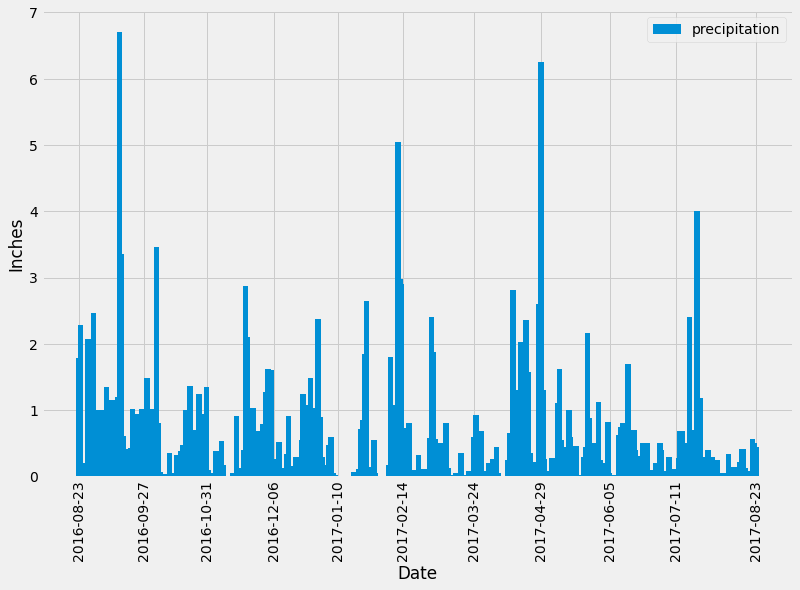

In [93]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.

last_date_12 = dt.datetime.strptime(recent_date, '%Y-%m-%d') - dt.timedelta(days=366)

twelve_months = session.query(Measurement.prcp).\
    order_by(Measurement.date.desc()).filter(Measurement.date > last_date_12).all()

print(twelve_months)

# Calculate the date one year from the last date in data set.

last_date = session.query(Measurement.date).order_by(Measurement.date.asc()).first().date
one_yr_from_last = dt.datetime.strptime(last_date, '%Y-%m-%d') + dt.timedelta(days=365)
print(f'The date one year from the last date in dataset is {one_yr_from_last}')

# Perform a query to retrieve the data and precipitation scores

results = session.query(Measurement.date,Measurement.prcp).\
    order_by(Measurement.date.asc()).filter(Measurement.date >= last_date_12).all()


# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results)
df.dropna(inplace=True)
df.set_index('date')
df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data

x_axis = df['date']
y_axis = df['prcp']
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(x_axis, y_axis, width=3.0)
ax.set_xlabel("Date")
ax.set_ylabel("Inches")
ax.legend(['precipitation'])
ax.set_xticks(x_axis[::202])
ax.set_xticklabels(x_axis[::202], rotation=90)
plt.savefig("Output/Precipitation.png")
plt.show()


In [94]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [95]:
# Design a query to calculate the total number stations in the dataset
count_stat = session.query(Measurement.station).group_by(Measurement.station).count()
print(f'The dataset has {count_stat} stations')

The dataset has 9 stations


In [96]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
list_station=session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()

list_station


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [97]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

first_station=list_station[0][0]

session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
               filter(Measurement.station == first_station).all()
    


[(54.0, 85.0, 71.66378066378067)]

2017-08-18
2016-08-18


<function matplotlib.pyplot.show(*args, **kw)>

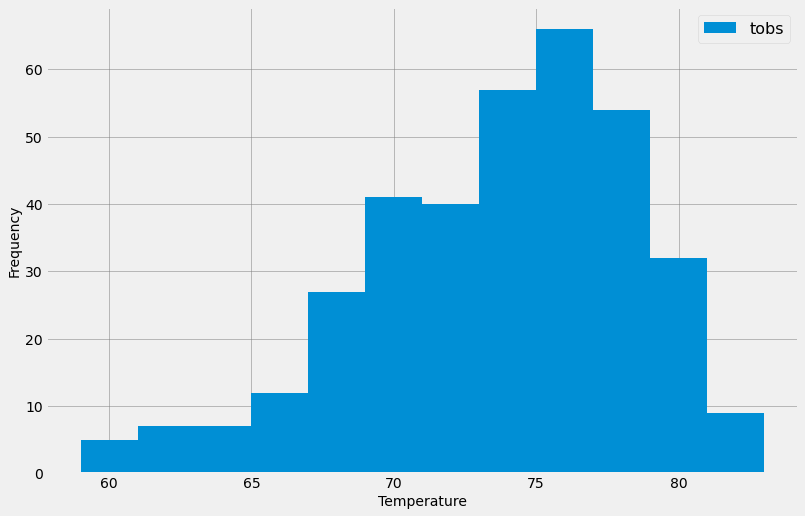

In [98]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

station_begin_date = session.query(Measurement.date).filter(Measurement.station == first_station).\
    order_by(Measurement.date.desc()).first().date

last_12_months_station = dt.datetime.strptime(station_begin_date, '%Y-%m-%d') - dt.timedelta(days=365)
m = last_12_months_station.strftime("%m")
y = last_12_months_station.strftime("%Y")
d = last_12_months_station.strftime("%d")
last_12_months_station = str(y+'-'+m+'-'+d)
print(station_begin_date)
print(last_12_months_station)

station = session.query(Measurement.date,Measurement.tobs).filter(Measurement.station == first_station).\
    filter(Measurement.date >= last_12_months_station).all()
station_df = pd.DataFrame(station)

#plot the results as a histogram
station_df.plot.hist(by='tobs', bins=12, figsize=(12,8))
plt.grid(color='grey', linestyle='-', linewidth=0.5)
plt.xlabel("Temperature", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend(bbox_to_anchor=(1,1), fontsize=16)
plt.savefig("Output/station_temps.png")
plt.show

# Close session

In [81]:
# Close Session
session.close()